<a href="https://colab.research.google.com/github/XzeraSpartan/CMPE-255-Data-Mining-Project-Group-5/blob/main/CMPE_255_Data_Mining_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import zipfile
import os


In [2]:
df = pd.read_csv("/content/drive/Shareddrives/CMPE_255_Dataset/household_power_consumption.txt", sep=';', parse_dates={'Datetime': ['Date', 'Time']},
                 infer_datetime_format=True, na_values=['?'])

# Drop rows with missing values
df.dropna(inplace=True)

In [3]:
# Feature Engineering
def add_time_features(df):
    df['year'] = df['Datetime'].dt.year
    df['month'] = df['Datetime'].dt.month
    df['day'] = df['Datetime'].dt.day
    df['hour'] = df['Datetime'].dt.hour
    df['day_of_week'] = df['Datetime'].dt.dayofweek
    df['weekend'] = (df['day_of_week'] >= 5).astype(int)
    return df

# Apply feature engineering to the dataset
df = add_time_features(df)



In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# Function to create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Splitting the DataFrame
train_size = int(len(df) * 1)
test_size = len(df) - int(len(df) * 0.8)
train = df[0:train_size]
test = df[int(len(df) * 0.8):len(df)]

# Normalize the training data
data_train = train['Global_active_power']
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_scaled = scaler.fit_transform(data_train.values.reshape(-1, 1))

# Create sequences for training dataa
sequence_length =5
X_train, y_train = create_sequences(data_train_scaled, sequence_length)
X_train = np.reshape(X_train, (X_train.shape[0], sequence_length, 1))

# Normalize the testing data
data_test = test['Global_active_power']
data_test_scaled = scaler.transform(data_test.values.reshape(-1, 1))

# Create sequences for testing data
X_test, y_test = create_sequences(data_test_scaled, sequence_length)
X_test = np.reshape(X_test, (X_test.shape[0], sequence_length, 1))



In [5]:

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=25, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')


In [6]:

# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, verbose=2)


Epoch 1/20
28818/28818 - 304s - loss: 6.4319e-04 - val_loss: 3.7488e-04 - 304s/epoch - 11ms/step
Epoch 2/20
28818/28818 - 296s - loss: 6.0659e-04 - val_loss: 3.6735e-04 - 296s/epoch - 10ms/step
Epoch 3/20
28818/28818 - 299s - loss: 5.9657e-04 - val_loss: 3.5924e-04 - 299s/epoch - 10ms/step
Epoch 4/20
28818/28818 - 303s - loss: 5.8935e-04 - val_loss: 3.6235e-04 - 303s/epoch - 11ms/step
Epoch 5/20
28818/28818 - 295s - loss: 5.8467e-04 - val_loss: 3.4910e-04 - 295s/epoch - 10ms/step
Epoch 6/20
28818/28818 - 292s - loss: 5.8039e-04 - val_loss: 4.3067e-04 - 292s/epoch - 10ms/step
Epoch 7/20
28818/28818 - 293s - loss: 5.7591e-04 - val_loss: 4.0997e-04 - 293s/epoch - 10ms/step
Epoch 8/20
28818/28818 - 290s - loss: 5.7278e-04 - val_loss: 3.4290e-04 - 290s/epoch - 10ms/step
Epoch 9/20
28818/28818 - 291s - loss: 5.7055e-04 - val_loss: 3.3562e-04 - 291s/epoch - 10ms/step
Epoch 10/20
28818/28818 - 289s - loss: 5.6906e-04 - val_loss: 3.4776e-04 - 289s/epoch - 10ms/step
Epoch 11/20
28818/28818 - 291

In [7]:

# Predict on the test data
predicted_test = model.predict(X_test)

# Inverse the scaling of the predictions and actual values
predicted_test = scaler.inverse_transform(predicted_test)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
test_mse = mean_squared_error(y_test, predicted_test)
print(f'Test Mean Squared Error: {test_mse}')

12808/12808 [==============================] - 43s 3ms/step
Test Mean Squared Error: 0.04444200673527271


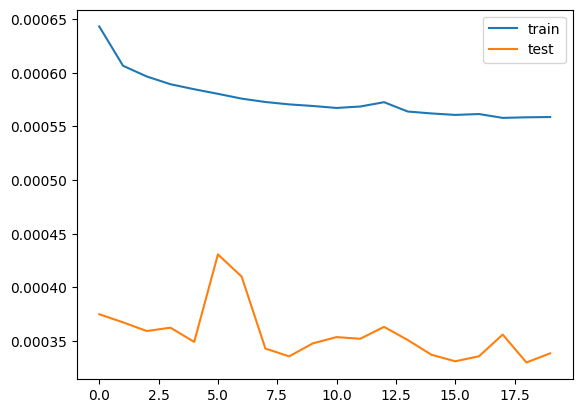

In [8]:
# Optionally plot the training loss and validation loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

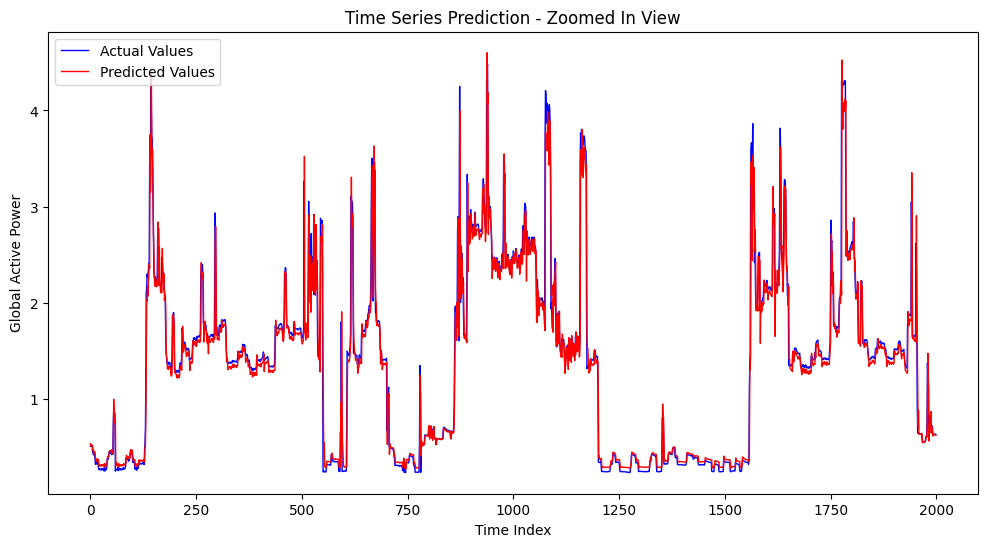

In [14]:
import matplotlib.pyplot as plt

# Flatten the arrays if they are 2D
actual = y_test.flatten()
predicted = predicted_test.flatten()


start_index = 0
end_index = 2000

# Create subsets based on the defined range
actual_subset = actual[start_index:end_index]
predicted_subset = predicted[start_index:end_index]

# Create the time series plot
plt.figure(figsize=(12, 6))
plt.plot(actual_subset, label='Actual Values', color='blue', linestyle='-', linewidth=1)
plt.plot(predicted_subset, label='Predicted Values', color='red', linestyle='-', linewidth=1)
plt.title('Time Series Prediction')
plt.xlabel('Time Index')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


In [15]:
from keras.models import load_model
from google.colab import files

model.save('time_series_analysis.h5')

files.download('time_series_analysis.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>